In [1]:
import pandas as pd
from tsaug import Drift, AddNoise, TimeWarp
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL


module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)


from utils.constants import spectral_bands
from utils.calculate_indices import CalculateIndices

# Load
df_trees_raw = pd.read_csv("../../data/Trainings_Datensatz.csv")

# Processing
df_trees = CalculateIndices.add_all_indices(df_trees_raw)
df_trees["month"] = pd.to_datetime(df_trees["time"]).dt.month
pd.set_option("display.max_columns", 500)

In [2]:
df_trees = df_trees.sample(frac=0.4)
df_trees["time"] = pd.to_datetime(df_trees["time"])

## Stationarität

#### --> Wenn man Feature basierte Modelle verwendet (RandomForest, SVM, XGBoost...) sollte man die Zeitreihe Stationär machen da sie Robustere features lifert (Mittelwert, Varianz, Frequenzen...)

#### --> Bei Deeplearing (RNN, LSTM, CNN) und Transformern (TST) ist Trendbreinigung eher vom Nachteil, da die Modelle diese Muster selbst erkennen und man potentiel Informationen verliert. Hier sollte man nur Normalisieren z.B. mit z-score und Data Augmentation. Zusätzlich würde eine Zyklische Zeitkodierung Sinn machen, weil das Modell dann Peridische Zeitabhängigkeiten besser versteht, da sie als Vektor Kodiert sind:

\[
\begin{aligned}
\text{month}_{\sin} &= \sin\left( 2\pi \cdot \frac{m}{12} \right) \\
\text{month}_{\cos} &= \cos\left( 2\pi \cdot \frac{m}{12} \right)
\end{aligned}
\]


\[
\begin{aligned}
x_{\sin} &= \sin\left( 2\pi \cdot \frac{x}{P} \right) \\
x_{\cos} &= \cos\left( 2\pi \cdot \frac{x}{P} \right)
\end{aligned}
\]



In [ ]:
df_trees_stationary = df_trees_raw.drop(columns=["doy", "disturbance_year", "id"])
df_trees_stationary["time"] = pd.to_datetime(df_trees["time"])
df_trees_stationary = df_trees_stationary[
    (df_trees_stationary["species"] == "oak")
    & (df_trees_stationary["time"].dt.year == 2020)
]

In [ ]:
df_trees_stationary = (
    df_trees_stationary.groupby(["time", "species"])
    .mean()
    .reset_index()[["b12", "time"]]
)

In [ ]:
px.line(df_trees_stationary, x="time", y="b12", title="Oak - 2020")

ADF-Test:
  Teststatistik: -2.1083
  p-Wert:       0.2412
  Kritische Werte: {'1%': np.float64(-3.44880082033912), '5%': np.float64(-2.869670179576637), '10%': np.float64(-2.5711012838861036)}
  ⇒ Nullhypothese nicht verwerfen: Nicht stationär

KPSS-Test:
  Teststatistik: 1.2607
  p-Wert:       0.0100
  Kritische Werte: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  ⇒ Nullhypothese verwerfen: Nicht stationär



/tmp/ipykernel_3488/1987994906.py:19: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




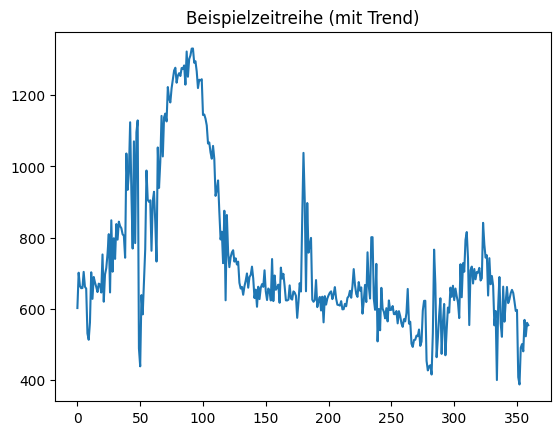

In [ ]:
# Beispiel mit species oak


# --- ADF Test ---
def adf_test(series):
    result = adfuller(series, autolag="AIC")
    print("ADF-Test:")
    print(f"  Teststatistik: {result[0]:.4f}")
    print(f"  p-Wert:       {result[1]:.4f}")
    print(f"  Kritische Werte: {result[4]}")
    if result[1] < 0.05:
        print("  ⇒ Nullhypothese verwerfen: Stationär\n")
    else:
        print("  ⇒ Nullhypothese nicht verwerfen: Nicht stationär\n")


# --- KPSS Test ---
def kpss_test(series):
    result = kpss(series, regression="c", nlags="auto")
    print("KPSS-Test:")
    print(f"  Teststatistik: {result[0]:.4f}")
    print(f"  p-Wert:       {result[1]:.4f}")
    print(f"  Kritische Werte: {result[3]}")
    if result[1] < 0.05:
        print("  ⇒ Nullhypothese verwerfen: Nicht stationär\n")
    else:
        print("  ⇒ Nullhypothese nicht verwerfen: Stationär\n")


# Tests ausführen
adf_test(df_trees_stationary["b12"])
kpss_test(df_trees_stationary["b12"])

# Plot zur Visualisierung
df_trees_stationary["b12"].plot(title="Beispielzeitreihe (mit Trend)")
plt.show()

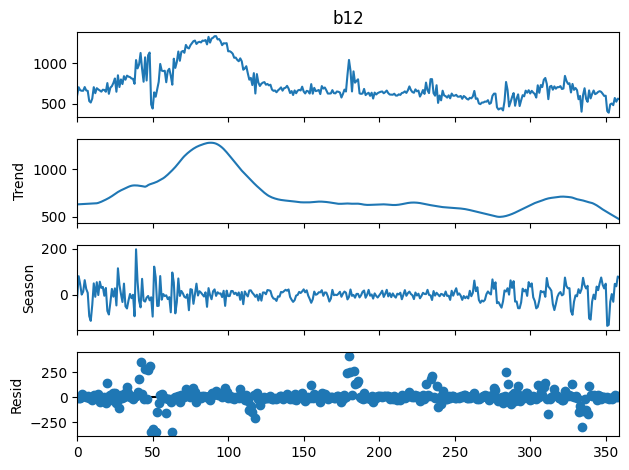

In [ ]:
stl = STL(df_trees_stationary["b12"], period=12, robust=True)
res = stl.fit()

# Komponenten
trend = res.trend
season = res.seasonal
residual = res.resid

# Visualisierung
res.plot()
plt.show()

# Trend- und Saisonbereinigung
df_trees_stationary["b12_adjusted"] = residual

In [ ]:
px.line(df_trees_stationary, x="time", y="b12_adjusted", title="Oak - 2020")

ADF-Test:
  Teststatistik: -8.0183
  p-Wert:       0.0000
  Kritische Werte: {'1%': np.float64(-3.448853029339765), '5%': np.float64(-2.869693115704379), '10%': np.float64(-2.571113512498422)}
  ⇒ Nullhypothese verwerfen: Stationär

KPSS-Test:
  Teststatistik: 0.0930
  p-Wert:       0.1000
  Kritische Werte: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  ⇒ Nullhypothese nicht verwerfen: Stationär



/tmp/ipykernel_3488/1647109396.py:19: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




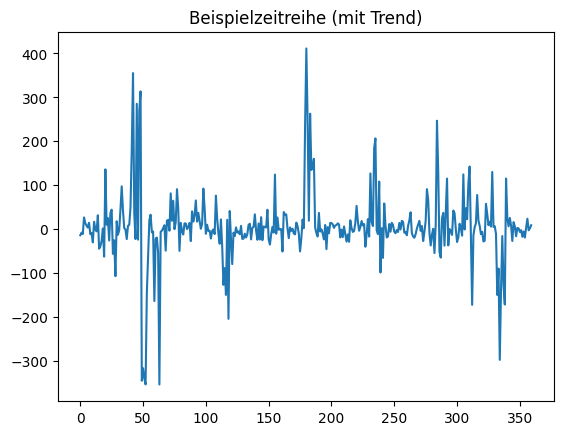

In [ ]:
# Beispiel mit species oak


# --- ADF Test ---
def adf_test(series):
    result = adfuller(series, autolag="AIC")
    print("ADF-Test:")
    print(f"  Teststatistik: {result[0]:.4f}")
    print(f"  p-Wert:       {result[1]:.4f}")
    print(f"  Kritische Werte: {result[4]}")
    if result[1] < 0.05:
        print("  ⇒ Nullhypothese verwerfen: Stationär\n")
    else:
        print("  ⇒ Nullhypothese nicht verwerfen: Nicht stationär\n")


# --- KPSS Test ---
def kpss_test(series):
    result = kpss(series, regression="c", nlags="auto")
    print("KPSS-Test:")
    print(f"  Teststatistik: {result[0]:.4f}")
    print(f"  p-Wert:       {result[1]:.4f}")
    print(f"  Kritische Werte: {result[3]}")
    if result[1] < 0.05:
        print("  ⇒ Nullhypothese verwerfen: Nicht stationär\n")
    else:
        print("  ⇒ Nullhypothese nicht verwerfen: Stationär\n")


# Tests ausführen
adf_test(df_trees_stationary["b12_adjusted"])
kpss_test(df_trees_stationary["b12_adjusted"])

# Plot zur Visualisierung
df_trees_stationary["b12_adjusted"].plot(title="Beispielzeitreihe (mit Trend)")
plt.show()